## Kubernetes Learing


### command


In [ ]:
#设置污点
kubectl taint nodes node1 key=value:effect

# 去除污点
kubectl taint nodes node1 key:effect-

# 去除所有污点
kubectl taint nodes node1 key-

kubectl taint nodes node1 tag=heima:PreferNoSchedule
kubectl taint nodes node1 tag=heima:NoSchedule
kubectl taint nodes node1 tag=heima:NoExecute 


kubectl describe pod pod-base -n dev # 查看pod内部的信息

kubectl exec <PodName> -n dev -it -c <ContainerName> /bin/sh #进入容器内部执行命令

kubectl get hpa -n dev -w

并非所有对象都在名字空间中
大多数 kubernetes 资源（例如 Pod、Service、副本控制器等）都位于某些名字空间中。 但是名字空间资源本身并不在名字空间中。而且底层资源， 例如节点和持久化卷不属于任何名字空间。

查看哪些 Kubernetes 资源在名字空间中，哪些不在名字空间中：

In [ ]:
# 位于名字空间中的资源
kubectl api-resources --namespaced=true

# 不在名字空间中的资源
kubectl api-resources --namespaced=false

字段选择器本质上是资源“过滤器（Filters）”。默认情况下，字段选择器/过滤器是未被应用的， 这意味着指定类型的所有资源都会被筛选出来。 这使得
`kubectl get pods` 和 `kubectl get pods --field-selector ""` 这两个 kubectl 查询是等价的。

In [ ]:
kubectl get pods --field-selector=status.phase!=Running,spec.restartPolicy=Always

能够跨多种资源类型来使用字段选择器。 下面这个 kubectl 命令将筛选出所有不在 default 命名空间中的 StatefulSet 和 Service：

In [ ]:
kubectl get statefulsets,services --all-namespaces --field-selector metadata.namespace!=default

属主关系与 Finalizer 
当你告诉 Kubernetes 删除一个资源，API 服务器允许管理控制器处理该资源的任何 Finalizer 规则。 Finalizer 防止意外删除你的集群所依赖的、用于正常运作的资源。 例如，如果你试图删除一个仍被 Pod 使用的 PersistentVolume，该资源不会被立即删除， 因为 PersistentVolume 有 kubernetes.io/pv-protection Finalizer。 相反，数据卷将进入 Terminating 状态， 直到 Kubernetes 清除这个 Finalizer，而这种情况只会发生在 PersistentVolume 不再被挂载到 Pod 上时。

要标记一个 Node 为不可调度，执行以下命令：

kubectl cordon $NODENAME

## 容器环境 
Kubernetes 的容器环境给容器提供了几个重要的资源：

文件系统，其中包含一个镜像 和一个或多个的卷
容器自身的信息
集群中其他对象的信息
### 容器信息
创建容器时正在运行的所有服务都可用作该容器的环境变量。 这里的服务仅限于新容器的 Pod 所在的名字空间中的服务，以及 Kubernetes 控制面的服务。

对于名为 foo 的服务，当映射到名为 bar 的容器时，定义了以下变量：
FOO_SERVICE_HOST=<其上服务正运行的主机>
FOO_SERVICE_PORT=<其上服务正运行的端口>


### 存储
kubernetes引入PV和PVC两种资源对象。

PV（Persistent Volume）是持久化卷的意思，是对底层的共享存储的一种抽象。一般情况下PV由kubernetes管理员进行创建和配置，它与底层具体的共享存储技术有关，并通过插件完成与共享存储的对接。

PVC（Persistent Volume Claim）是持久卷声明的意思，是用户对于存储需求的一种声明。换句话说，PVC其实就是用户向kubernetes系统发出的一种资源需求申请。

#### PV 
PV是存储资源的抽象，下面是资源清单文件 
PV 的关键配置参数说明：

存储类型

底层实际存储的类型，kubernetes支持多种存储类型，每种存储类型的配置都有所差异

存储能力（capacity）

目前只支持存储空间的设置( storage=1Gi )，不过未来可能会加入IOPS、吞吐量等指标的配置

访问模式（accessModes）

用于描述用户应用对存储资源的访问权限，访问权限包括下面几种方式：

ReadWriteOnce（RWO）：读写权限，但是只能被单个节点挂载
ReadOnlyMany（ROX）： 只读权限，可以被多个节点挂载
ReadWriteMany（RWX）：读写权限，可以被多个节点挂载
需要注意的是，底层不同的存储类型可能支持的访问模式不同

回收策略（persistentVolumeReclaimPolicy）

当PV不再被使用了之后，对其的处理方式。目前支持三种策略：

Retain （保留） 保留数据，需要管理员手工清理数据
Recycle（回收） 清除 PV 中的数据，效果相当于执行 rm -rf /thevolume/*
Delete （删除） 与 PV 相连的后端存储完成 volume 的删除操作，当然这常见于云服务商的存储服务
需要注意的是，底层不同的存储类型可能支持的回收策略不同

存储类别

PV可以通过storageClassName参数指定一个存储类别

具有特定类别的PV只能与请求了该类别的PVC进行绑定
未设定类别的PV则只能与不请求任何类别的PVC进行绑定
状态（status）

一个 PV 的生命周期中，可能会处于4中不同的阶段：

Available（可用）： 表示可用状态，还未被任何 PVC 绑定
Bound（已绑定）： 表示 PV 已经被 PVC 绑定
Released（已释放）： 表示 PVC 被删除，但是资源还未被集群重新声明
Failed（失败）： 表示该 PV 的自动回收失败

#### PVC
PVC是资源的申请，用来声明对存储空间、访问模式、存储类别需求信息。为pod添加pvc 
``` volumes:
    - name: volume
      persistentVolumeClaim:
        claimName: pvc1
        readOnly: false
```

#### 生命周期

PVC和PV是一一对应的，PV和PVC之间的相互作用遵循以下生命周期：

资源供应：管理员手动创建底层存储和PV

资源绑定：用户创建PVC，kubernetes负责根据PVC的声明去寻找PV，并绑定

在用户定义好PVC之后，系统将根据PVC对存储资源的请求在已存在的PV中选择一个满足条件的

一旦找到，就将该PV与用户定义的PVC进行绑定，用户的应用就可以使用这个PVC了
如果找不到，PVC则会无限期处于Pending状态，直到等到系统管理员创建了一个符合其要求的PV
PV一旦绑定到某个PVC上，就会被这个PVC独占，不能再与其他PVC进行绑定了

资源使用：用户可在pod中像volume一样使用pvc

Pod使用Volume的定义，将PVC挂载到容器内的某个路径进行使用。

资源释放：用户删除pvc来释放pv

当存储资源使用完毕后，用户可以删除PVC，与该PVC绑定的PV将会被标记为“已释放”，但还不能立刻与其他PVC进行绑定。通过之前PVC写入的数据可能还被留在存储设备上，只有在清除之后该PV才能再次使用。

资源回收：kubernetes根据pv设置的回收策略进行资源的回收

对于PV，管理员可以设定回收策略，用于设置与之绑定的PVC释放资源之后如何处理遗留数据的问题。只有PV的存储空间完成回收，才能供新的PVC绑定和使用
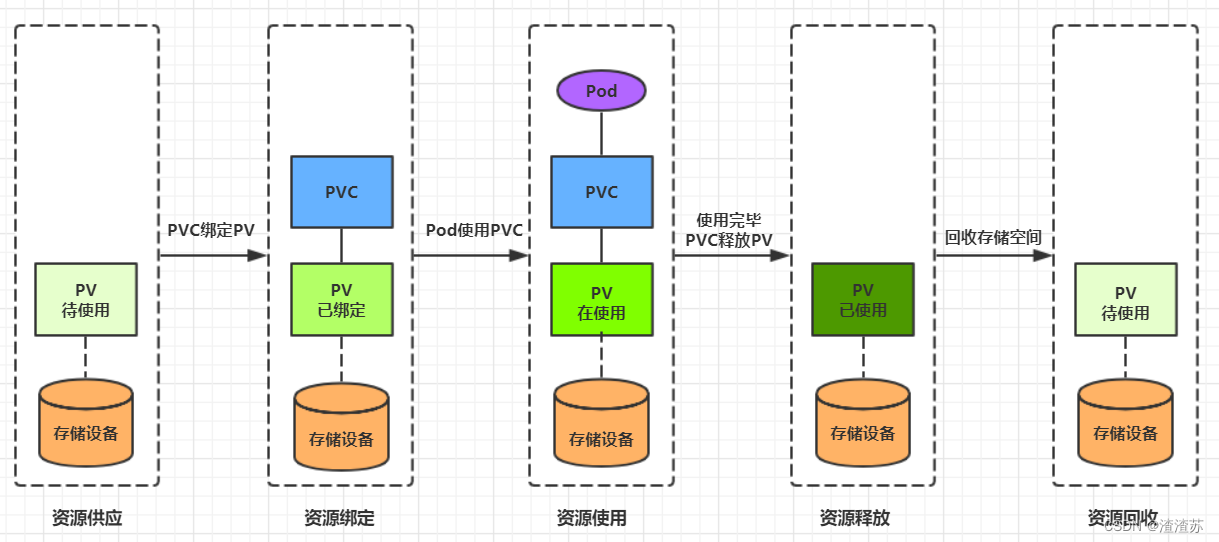


#### ConfigMap
ConfigMap是一种比较特殊的存储卷，它的主要作用是用来存储配置信息的。
```
apiVersion: v1
kind: Pod
metadata:
  name: myapp
  labels:
    name: myapp
spec:
  containers:
  - name: myapp
    image: <Image>
    resources:
      limits:
        memory: "128Mi"
        cpu: "500m"  #1000m = 1core
    ports:
      - containerPort: 80
  restartPolicy: Never   
  volumes:
    - name: config
      configMap:
        name:  myconfigmap
        optional: true

```

### 安全认证

访问控制概述
Kubernetes作为一个分布式集群的管理工具，保证集群的安全性是其一个重要的任务。所谓的安全性其实就是保证对Kubernetes的各种客户端进行认证和鉴权操作。

客户端

在Kubernetes集群中，客户端通常有两类：

- User Account：一般是独立于kubernetes之外的其他服务管理的用户账号。
- Service Account：kubernetes管理的账号，用于为Pod中的服务进程在访问Kubernetes时提供身份标识


认证、授权与准入控制

ApiServer是访问及管理资源对象的唯一入口。任何一个请求访问ApiServer，都要经过下面三个流程：

Authentication（认证）：身份鉴别，只有正确的账号才能够通过认证
Authorization（授权）： 判断用户是否有权限对访问的资源执行特定的动作
Admission Control（准入控制）：用于补充授权机制以实现更加精细的访问控制功能。


In [ ]:
kubectl create serviceaccount dashboard-admin -n kubernetes-dashboard
kubectl create clusterrolebinding dashboard-admin-rb --clusterrole=cluster-admin --serviceaccount=kubernetes-dashboard:dashboard-admin
kubectl get secrets -n kubernetes-dashboard | grep dashboard-admin  #获取账号token
kubectl describe secrets dashboard-admin-token-xbqhh -n kubernetes-dashboard

> 外网访问不到时需要进行端口转发 ，可以使用loadBalancer或者ingress 


In [ ]:
kubectl port-forward svc/nginx 30000:80 --address='0.0.0.0'

### Kubernetes 网络模型 
#### NodePort 
> 外部网络与Service Cluster Ip的桥梁
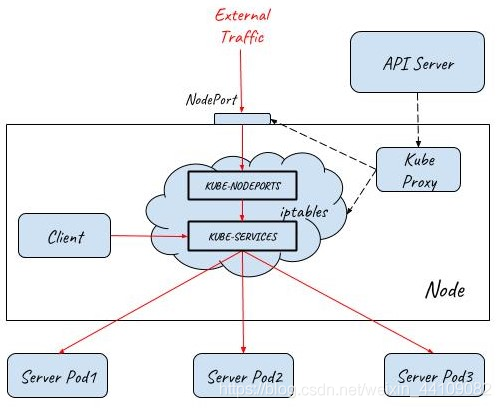

#### 不同port的区别

##### nodePort
nodePort提供了集群外部客户端访问service的一种方式，:nodePort提供了集群外部客户端访问service的端口，即nodeIP:nodePort提供了外部流量访问k8s集群中service的入口。

比如外部用户要访问k8s集群中的一个Web应用，那么我们可以配置对应service的type=NodePort，nodePort=30001。其他用户就可以通过浏览器http://node:30001访问到该web服务。

而数据库等服务可能不需要被外界访问，只需被内部服务访问即可，那么我们就不必设置service的NodePort。

##### port
port是暴露在cluster ip上的端口，:port提供了集群内部客户端访问service的入口，即clusterIP:port。

mysql容器暴露了3306端口（参考DockerFile），集群内其他容器通过33306端口访问mysql服务，但是外部流量不能访问mysql服务，因为mysql服务没有配置NodePort。对应的service.yaml如下：
```
apiVersion: v1
kind: Service
metadata:
  name: mysql-service
spec:
  ports:
  - port: 33306
    targetPort: 3306
  selector:
    name: mysql-pod


```

##### targetPort
targetPort是pod上的端口，从port/nodePort上来的数据，经过kube-proxy流入到后端pod的targetPort上，最后进入容器。

与制作容器时暴露的端口一致（使用DockerFile中的EXPOSE），例如官方的nginx（参考DockerFile）暴露80端口。 对应的service.yaml如下：

```
apiVersion: v1
kind: Service
metadata:
  name: nginx-service
spec:
  type: NodePort            // 配置NodePort，外部流量可访问k8s中的服务
  ports:
  - port: 30080             // 服务访问端口 cluster ip port 
    targetPort: 80          // pod控制器中定义的端口
    nodePort: 30001         // NodePort  30001 -> 300080 -> 80 
  selector:
    name: nginx-pod

```

##### containerPort
containerPort是在pod控制器中定义的、pod中的容器需要暴露的端口。

> 总的来说，port和nodePort都是service的端口，前者暴露给k8s集群内部服务访问，后者暴露给k8s集群外部流量访问。从这两个端口到来的数据都需要经过反向代理kube-proxy，流入后端pod的targetPort上，最后到达pod内容器的containerPort。
